In [1]:
from pytorch_tools import CreateDataset, train_model_cls, train_model_reg, plot_metrics
from train_models import ClassifierTrainer, RegressorTrainer

/Users/aleksejkitajskij/Desktop/DS-Lifehacks/pytorch/pytorch_tools.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/anaconda3/envs/goit/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## binary classification

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_1_Lecture_2_Class_Spaceship_Titanic.csv')
df = df.set_index('PassengerId')

TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET]

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])

df["HomePlanet"].fillna('Gallifrey', inplace=True)
df["Destination"].fillna('Skaro', inplace=True)

df['CryoSleep_is_missing'] = df['CryoSleep'].isna().astype(int)
df['VIP_is_missing'] = df['VIP'].isna().astype(int)

df["CryoSleep"].fillna(False, inplace=True)
df["VIP"].fillna(False, inplace=True)

df["CryoSleep"] = df["CryoSleep"].astype(int)
df["VIP"] = df["VIP"].astype(int)

dummies = pd.get_dummies(df.loc[:, ['HomePlanet', 'Destination']], dtype=int)

df = pd.concat([df, dummies], axis=1)
df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

df[TARGET] = df[TARGET].astype(int)

df.drop(["Name" ,"Cabin"] , axis=1 ,inplace = True)

In [4]:
X = df.drop(TARGET , axis =1 ).values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33, stratify = y)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=len(X_train),
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=len(X_test),
                              num_workers=0
                             )

In [6]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [7]:
input_dim = X_train.shape[1]
model = Net(input_dim)
parameters = list(model.parameters())

criterion = nn.BCELoss()
optimizer = optim.SGD(parameters, lr=0.01)

In [8]:
parameters

[Parameter containing:
 tensor([[-0.0337, -0.0543,  0.1383,  0.1539, -0.1326,  0.0359,  0.1966,  0.0727,
          -0.1345, -0.0163,  0.2293, -0.0414,  0.0122,  0.1884,  0.1601, -0.0697,
           0.0823,  0.1182]], requires_grad=True),
 Parameter containing:
 tensor([0.1433], requires_grad=True)]

In [9]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=2,
                            device='cpu')

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=100,
            info_every_iter=5,
            show_val_metrics=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/100] Train Loss: 0.7881 Acc: 0.3839 Rec: 0.5752 Prec: 0.4187
Epoch [10/100] Train Loss: 0.7799 Acc: 0.3862 Rec: 0.5759 Prec: 0.4201
Epoch [15/100] Train Loss: 0.7720 Acc: 0.3884 Rec: 0.5769 Prec: 0.4216
Epoch [20/100] Train Loss: 0.7643 Acc: 0.3898 Rec: 0.5776 Prec: 0.4225
Epoch [25/100] Train Loss: 0.7568 Acc: 0.3982 Rec: 0.5926 Prec: 0.4293
Epoch [30/100] Train Loss: 0.7496 Acc: 0.4172 Rec: 0.6277 Prec: 0.4444
Epoch [35/100] Train Loss: 0.7426 Acc: 0.4318 Rec: 0.6481 Prec: 0.4550
Epoch [40/100] Train Loss: 0.7358 Acc: 0.4421 Rec: 0.6604 Prec: 0.4623
Epoch [45/100] Train Loss: 0.7293 Acc: 0.4457 Rec: 0.6614 Prec: 0.4647
Epoch [50/100] Train Loss: 0.7229 Acc: 0.4516 Rec: 0.6652 Prec: 0.4687
Epoch [55/100] Train Loss: 0.7168 Acc: 0.4653 Rec: 0.6829 Prec: 0.4784
Epoch [60/100] Train Loss: 0.7109 Acc: 0.4725 Rec: 0.6874 Prec: 0.4833
Epoch [65/100] Train Loss: 0.7051 Acc: 0.4907 Rec: 0.7061 Prec: 0.4960
Epoch [70/100] Train Loss: 0.6995 Acc: 0.5079 Rec: 0.7262 Prec: 0.5080
Epoch [

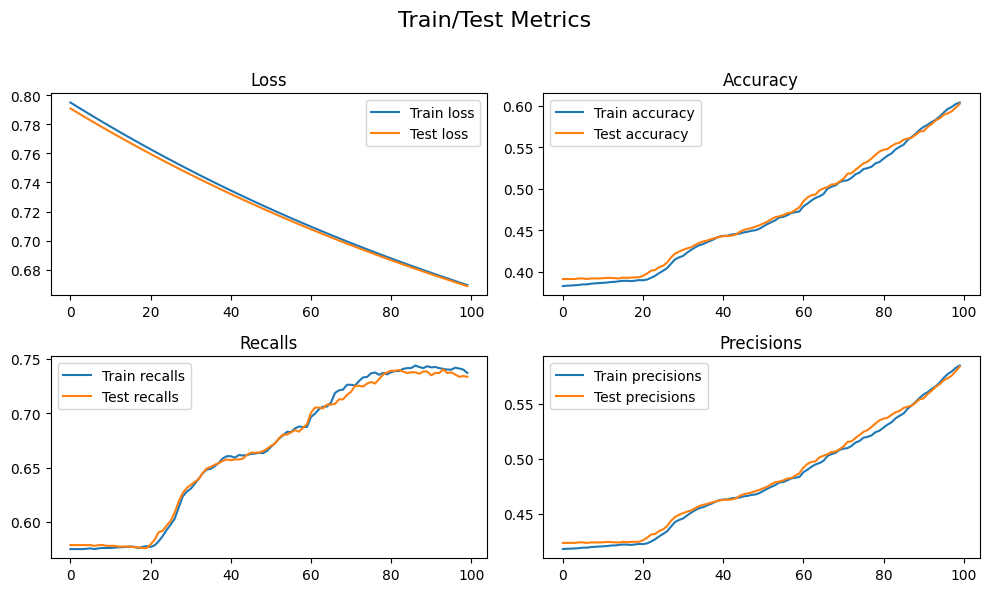

In [10]:
trainer.plot_metrics()

In [11]:
metrics, model = train_model_cls(
    num_classes=2,
    num_epoch=100,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    info_every_iter=5
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/100] Train Loss: 0.6651 Acc: 0.6161 Rec: 0.7266 Prec: 0.5978
Epoch [10/100] Train Loss: 0.6608 Acc: 0.6305 Rec: 0.7259 Prec: 0.6123
Epoch [15/100] Train Loss: 0.6567 Acc: 0.6362 Rec: 0.7225 Prec: 0.6189
Epoch [20/100] Train Loss: 0.6526 Acc: 0.6468 Rec: 0.7249 Prec: 0.6297
Epoch [25/100] Train Loss: 0.6487 Acc: 0.6549 Rec: 0.7221 Prec: 0.6393
Epoch [30/100] Train Loss: 0.6449 Acc: 0.6633 Rec: 0.7208 Prec: 0.6493
Epoch [35/100] Train Loss: 0.6412 Acc: 0.6671 Rec: 0.7167 Prec: 0.6548
Epoch [40/100] Train Loss: 0.6376 Acc: 0.6724 Rec: 0.7129 Prec: 0.6623
Epoch [45/100] Train Loss: 0.6342 Acc: 0.6782 Rec: 0.7105 Prec: 0.6703
Epoch [50/100] Train Loss: 0.6308 Acc: 0.6830 Rec: 0.7105 Prec: 0.6764
Epoch [55/100] Train Loss: 0.6276 Acc: 0.6870 Rec: 0.7037 Prec: 0.6839
Epoch [60/100] Train Loss: 0.6244 Acc: 0.6902 Rec: 0.7030 Prec: 0.6885
Epoch [65/100] Train Loss: 0.6213 Acc: 0.6933 Rec: 0.7027 Prec: 0.6928
Epoch [70/100] Train Loss: 0.6184 Acc: 0.6975 Rec: 0.7027 Prec: 0.6984
Epoch [

In [12]:
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy().round()

accuracy_score(y_test, y_pred)

0.5402579295921924

In [13]:
parameters

[Parameter containing:
 tensor([[ 0.3464, -0.0979,  0.0650, -0.0845, -0.0269,  0.0279, -0.0251, -0.0982,
          -0.0763, -0.0163,  0.0823,  0.1510,  0.0203,  0.1636,  0.2100, -0.0202,
           0.0611,  0.0511]], requires_grad=True),
 Parameter containing:
 tensor([0.0942], requires_grad=True)]

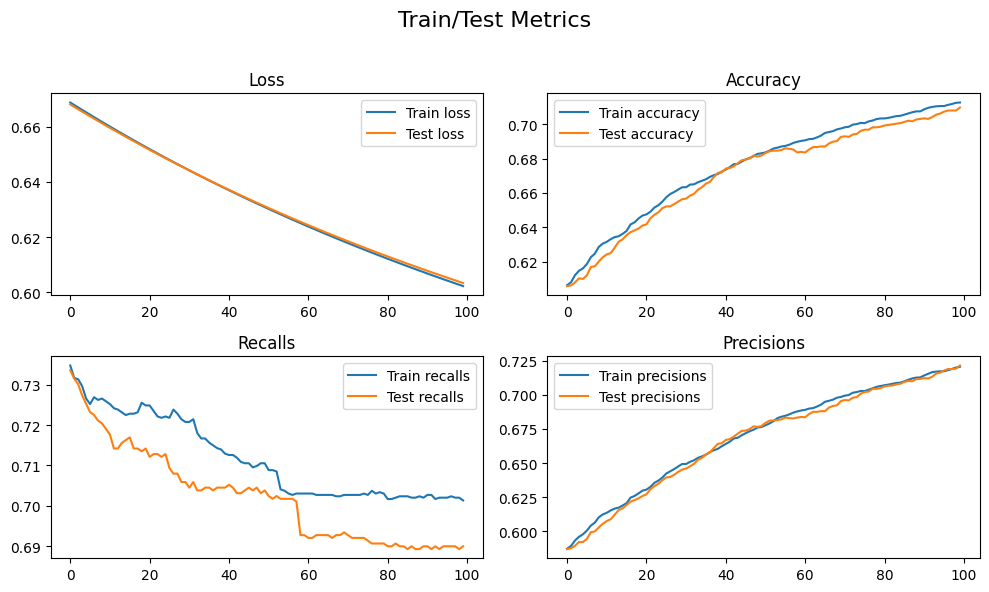

In [14]:
plot_metrics(metrics)

## multyclass classification

In [15]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv('data/Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [17]:
X = df.drop('species', axis =1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [18]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [19]:
train_dataset.scaler

StandardScaler()

In [20]:
num_classes = len(np.unique(y_train))
num_classes

3

In [21]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [22]:
model = Net(X_train.shape[1], 20, num_classes)
parameters = list(model.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(parameters, lr=0.01)

In [23]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=num_classes,
                            device='mps',
                            callbacks=None)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=50,
            info_every_iter=10,
            show_val_metrics=False)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/50] Train Loss: 1.0848 Acc: 0.4800 Rec: 0.4800 Prec: 0.3774
Epoch [20/50] Train Loss: 0.9887 Acc: 0.7781 Rec: 0.7781 Prec: 0.8899
Epoch [30/50] Train Loss: 0.8990 Acc: 0.7702 Rec: 0.7702 Prec: 0.9009
Epoch [40/50] Train Loss: 0.8267 Acc: 0.7670 Rec: 0.7670 Prec: 0.8988
Epoch [50/50] Train Loss: 0.7748 Acc: 0.7966 Rec: 0.7966 Prec: 0.9108


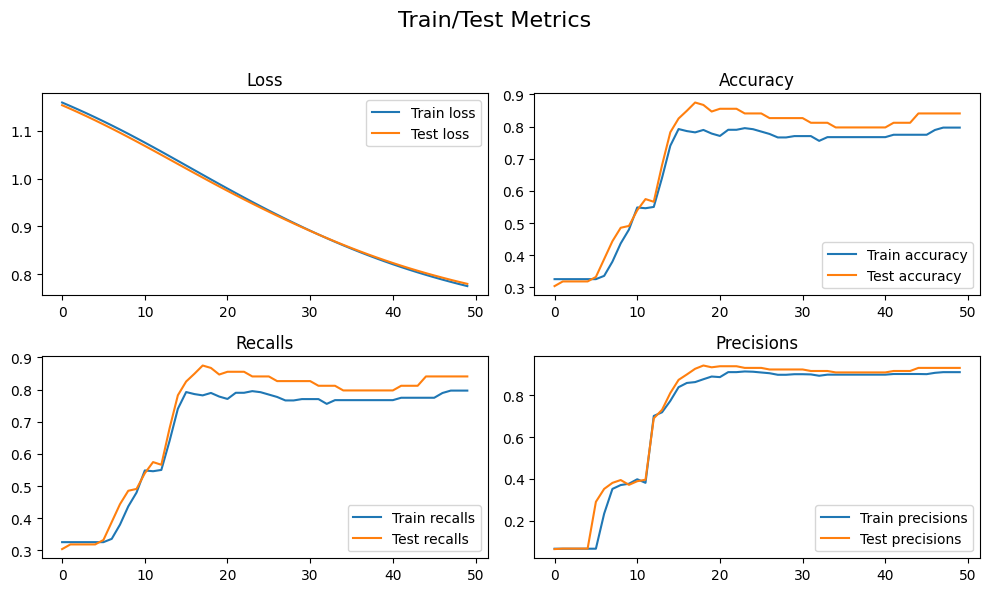

In [24]:
trainer.plot_metrics()

In [25]:
metrics, model = train_model_cls(
    num_classes=num_classes,
    num_epoch=50,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50] Train Loss: 0.7706 Acc: 0.7966 Rec: 0.7966 Prec: 0.9108
Epoch [2/50] Train Loss: 0.7666 Acc: 0.7966 Rec: 0.7966 Prec: 0.9108
Epoch [3/50] Train Loss: 0.7627 Acc: 0.7966 Rec: 0.7966 Prec: 0.9108
Epoch [4/50] Train Loss: 0.7589 Acc: 0.8114 Rec: 0.8114 Prec: 0.9166
Epoch [5/50] Train Loss: 0.7553 Acc: 0.8114 Rec: 0.8114 Prec: 0.9166
Epoch [6/50] Train Loss: 0.7518 Acc: 0.8114 Rec: 0.8114 Prec: 0.9166
Epoch [7/50] Train Loss: 0.7484 Acc: 0.8188 Rec: 0.8188 Prec: 0.9200
Epoch [8/50] Train Loss: 0.7451 Acc: 0.8188 Rec: 0.8188 Prec: 0.9200
Epoch [9/50] Train Loss: 0.7419 Acc: 0.8262 Rec: 0.8262 Prec: 0.9235
Epoch [10/50] Train Loss: 0.7388 Acc: 0.8336 Rec: 0.8336 Prec: 0.9270
Epoch [11/50] Train Loss: 0.7358 Acc: 0.8485 Rec: 0.8485 Prec: 0.9344
Epoch [12/50] Train Loss: 0.7328 Acc: 0.8485 Rec: 0.8485 Prec: 0.9344
Epoch [13/50] Train Loss: 0.7299 Acc: 0.8485 Rec: 0.8485 Prec: 0.9344
Epoch [14/50] Train Loss: 0.7271 Acc: 0.8485 Rec: 0.8485 Prec: 0.9344
Epoch [15/50] Train Loss: 0.7

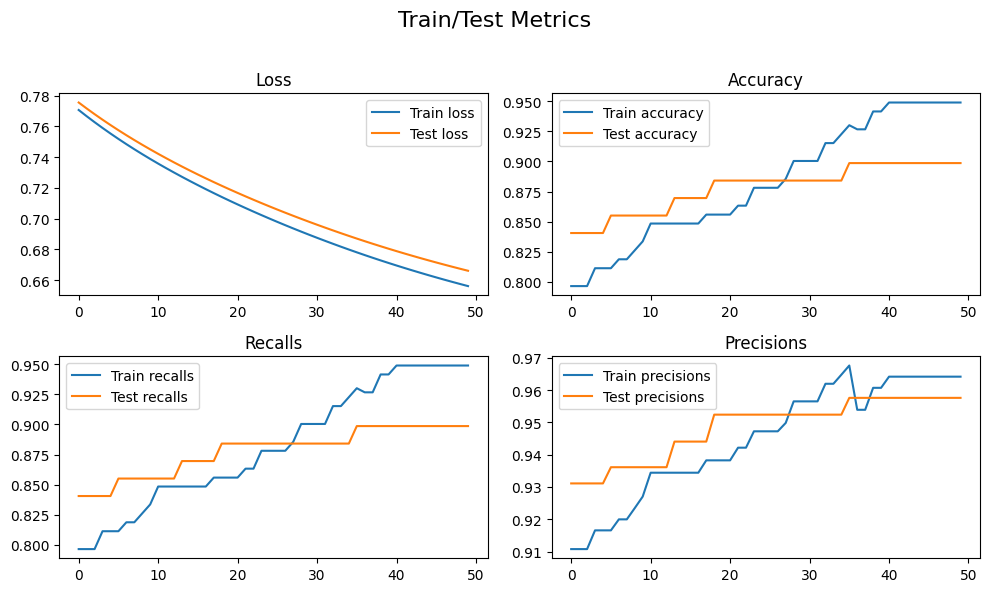

In [26]:
plot_metrics(metrics)

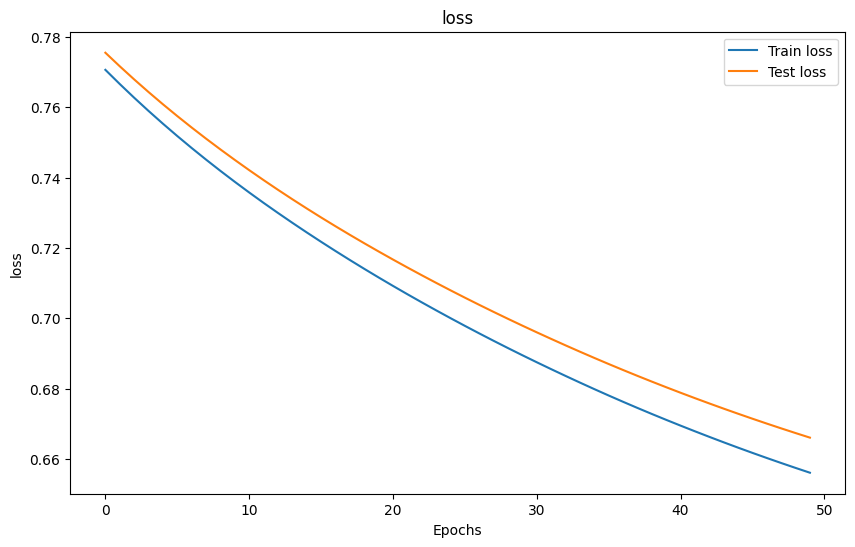

In [27]:
plot_metrics(metrics, 'loss')

## regression

In [28]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [29]:
data_path = 'data/Module_2_Lecture_2_Class_bigmart_data.csv'
data = pd.read_csv(data_path)
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']
data['Item_Visibility'] = (data['Item_Visibility']
                           .mask(data['Item_Visibility'].eq(0), np.nan))

data['Item_Visibility_Avg'] = (data
                               .groupby(['Item_Type',
                                         'Outlet_Type'])['Item_Visibility']
                               .transform('mean'))

data['Item_Visibility'] = (
    data['Item_Visibility'].fillna(data['Item_Visibility_Avg']))

data['Item_Visibility_Ratio'] = (
    data['Item_Visibility'] / data['Item_Visibility_Avg'])

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})

data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [30]:
X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num.drop(['Item_Outlet_Sales',
                       'Item_Visibility_Avg'], axis=1).values,
        data_cat.drop('Item_Identifier', axis=1).values,
        data['Item_Outlet_Sales'].values,
        test_size=0.2,
        random_state=42))

num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')
X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6818, 12), (1705, 12), (6818,), (1705,))

In [32]:
train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [33]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            
            nn.Linear(256, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, 64),
            torch.nn.ReLU(),
            
            nn.Linear(64, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [34]:
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [35]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Використовується пристрій:", device)

Використовується пристрій: mps


In [36]:
trainer = RegressorTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            device=device,
                            callbacks=[])

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=10,
            info_every_iter=1,
            show_val_metrics=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 7709138.9300 MSE: 7709136.5000 MAE: 2181.5156 RMSE: 2776.5332
Epoch [2/10] Train Loss: 6023545.4273 MSE: 6023544.0000 MAE: 1835.4297 RMSE: 2454.2909
Epoch [3/10] Train Loss: 2522636.6295 MSE: 2522637.2500 MAE: 1114.7921 RMSE: 1588.2812
Epoch [4/10] Train Loss: 1564149.0346 MSE: 1564148.7500 MAE: 940.1801 RMSE: 1250.6593
Epoch [5/10] Train Loss: 1427055.3114 MSE: 1427055.5000 MAE: 901.5411 RMSE: 1194.5943
Epoch [6/10] Train Loss: 1356852.7603 MSE: 1356852.3750 MAE: 871.0527 RMSE: 1164.8401
Epoch [7/10] Train Loss: 1317299.2156 MSE: 1317298.7500 MAE: 850.1633 RMSE: 1147.7364
Epoch [8/10] Train Loss: 1294078.7373 MSE: 1294078.3750 MAE: 835.6667 RMSE: 1137.5757
Epoch [9/10] Train Loss: 1279951.0265 MSE: 1279951.3750 MAE: 825.7027 RMSE: 1131.3494
Epoch [10/10] Train Loss: 1270880.2543 MSE: 1270880.2500 MAE: 818.6876 RMSE: 1127.3332


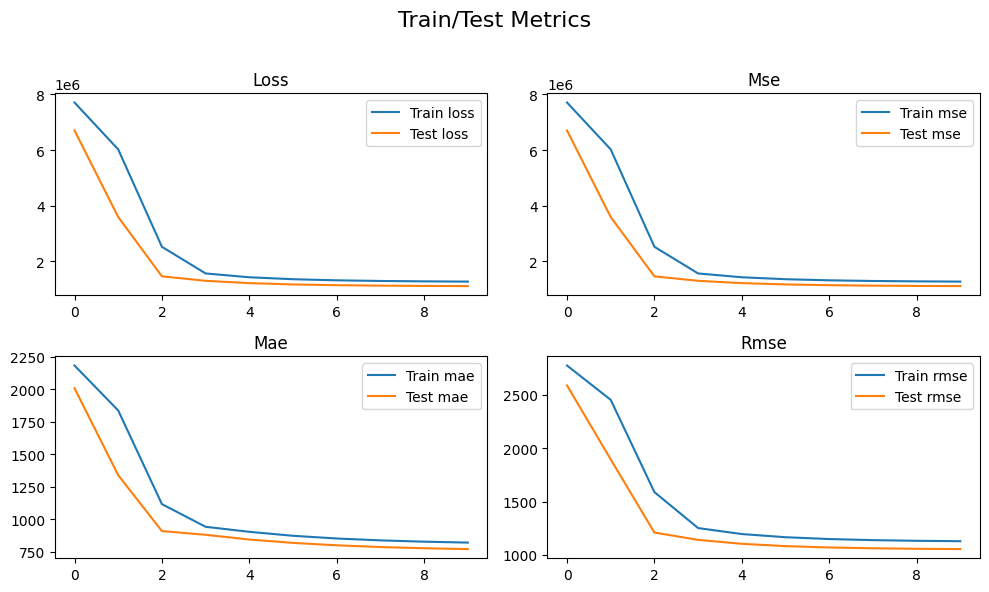

In [37]:
trainer.plot_metrics()

In [38]:
metrics, model = train_model_reg(num_epoch=10,
                    train_dataloader = train_dataloader,
                    test_dataloader = test_dataloader,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device,
                    show_val_metrics=True,
                    info_every_iter=2
                    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2/10] Train Loss: 1260107.9512 MSE: 1260108.0000 MAE: 809.8937 RMSE: 1122.5453
Epoch [2/10] Val Loss: 1102066.4272 MSE: 1102066.7500 MAE: 760.1141 RMSE: 1049.7937
Epoch [4/10] Train Loss: 1253532.2789 MSE: 1253531.8750 MAE: 804.6663 RMSE: 1119.6124
Epoch [4/10] Val Loss: 1097577.1058 MSE: 1097577.1250 MAE: 755.3666 RMSE: 1047.6532
Epoch [6/10] Train Loss: 1248526.6757 MSE: 1248526.8750 MAE: 801.1696 RMSE: 1117.3750
Epoch [6/10] Val Loss: 1094250.6796 MSE: 1094250.8750 MAE: 752.3636 RMSE: 1046.0645
Epoch [8/10] Train Loss: 1244339.2466 MSE: 1244339.1250 MAE: 798.5148 RMSE: 1115.4995
Epoch [8/10] Val Loss: 1091481.5302 MSE: 1091481.6250 MAE: 750.1440 RMSE: 1044.7400
Epoch [10/10] Train Loss: 1240777.2712 MSE: 1240777.1250 MAE: 796.3920 RMSE: 1113.9018
Epoch [10/10] Val Loss: 1089266.6827 MSE: 1089266.7500 MAE: 748.5726 RMSE: 1043.6794


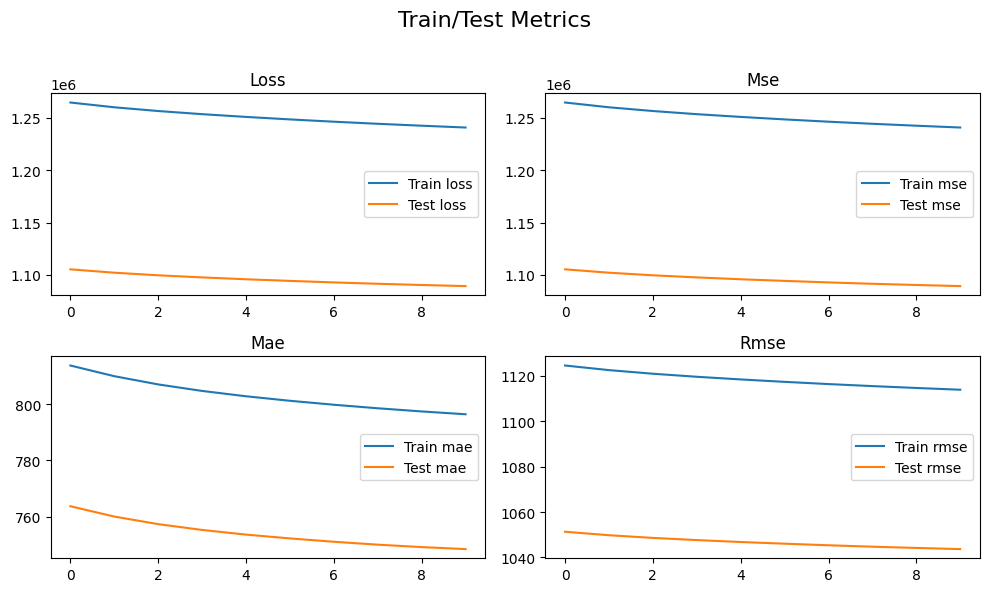

In [39]:
plot_metrics(metrics)